In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

%matplotlib inline

## Loading and Splitting Transformed Data

In [17]:
data_dir = 'input_data'
model_dir = 'models'
seed=0
scoring='neg_mean_squared_log_error'

In [3]:
train_df = pd.read_csv(os.path.join(data_dir, 'train_preprocessed.csv'), index_col='ID')

In [4]:
X = train_df.iloc[:, 1:]
y = train_df['target']

In [12]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=seed)

## Model Selection

In [ ]:
models = []
models.append(('RCV', Ridge()))
models.append(('SVM', SVR()))
models.append(('RFR', RandomForestRegressor()))
models.append(('GBM', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('SGD', SGDRegressor()))
models.append(('LSO', Lasso()))

In [ ]:
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

## Hyperparameter tuning

It looks like a baseline gradient boosted regression performed the best on the training data. I will focus on tuning the hyperparamters of this algorithm further using GridsearchCV

In [13]:
GBRegressor = GradientBoostingRegressor()
grid_values_grdb = {'n_estimators' : [1, 10, 100], 'max_depth' : [1, 3, 5], 'learning_rate' : [.001, .01, .1], 'loss' : ['ls', 'lad', 'huber', 'quantile']}
GBRegressor_CV = model_selection.GridSearchCV(GBRegressor, param_grid = grid_values_grdb, scoring=scoring)

In [14]:
GBRegressor_CV.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [18]:
GRB_predicted = GBRegressor_CV.predict(X_test)

In [19]:
np.sqrt(mean_squared_log_error(y_test, GRB_predicted))

0.22864870143571692

Text(0, 0.5, 'y Predicted')

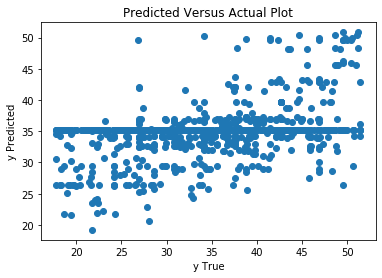

In [20]:
plt.scatter(y_test, GRB_predicted)
plt.title('Predicted Versus Actual Plot')
plt.xlabel('y True')
plt.ylabel('y Predicted')


It seems to do pretty well. I will fit to the full training set to be deployed.

In [9]:
GBRegressor_CV.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

## Saving Model for Deployment

In [21]:
import pickle
import datetime
time = datetime.datetime.now().strftime("%D").replace('/', '_')

#Creating model directory
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Saving serialized model data to directory
filename = 'GRB_model_{}'.format(time)
pickle.dump(GBRegressor_CV, open(os.path.join(model_dir, filename), 'wb'))